# AnnData Pre-Processing: Normalization and SCVI

**Author:** Bhavya Singh

**Affiliation:** Icahn School of Medicine at Mount Sinai, Brian D. Brown Lab

**Date:** 2025-12-18


# Load Packages

In [2]:
import spatialdata as sd
from spatialdata_io import xenium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

from pathlib import Path
from spatialdata import SpatialData, read_zarr

/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# Load Data

In [ ]:
sc.settings.verbosity = 3   

In [42]:
zarr_path = "jmt.zarr"
sdata_xenium = read_zarr(zarr_path)

version mismatch: detected: RasterFormatV02, requested: FormatV04


In [17]:
sdata_xenium

SpatialData object, with associated Zarr store: /sc/arion/projects/Perturb-map/BhavyaSingh/data/lab_data/jmt.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (4, 112088, 53965), (4, 56044, 26982), (4, 28022, 13491), (4, 14011, 6745), (4, 7005, 3372)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (112088, 53965), (56044, 26982), (28022, 13491), (14011, 6745), (7005, 3372)
│     └── 'nucleus_labels': DataTree[yx] (112088, 53965), (56044, 26982), (28022, 13491), (14011, 6745), (7005, 3372)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (651399, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (651399, 2) (2D shapes)
│     ├── 'nucleus_boundaries': GeoDataFrame shape: (649479, 1) (2D shapes)
│     └── 'tumor_regions': GeoDataFrame shape: (6, 3) (2D shapes)
└── Tables
      └── 'table': AnnData (641951, 480)
with coordinate systems:
    ▸ 'global', with elements:
     

In [43]:
sdata_xenium.tables["table"]

AnnData object with n_obs × n_vars = 641951 × 480
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'Region_ID', 'Treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'
    layers: 'raw'

# Make AnnData

In [44]:
adata = sdata_xenium.tables["table"]

In [45]:
adata.obs["Region_ID"].value_counts()

Region_ID
2LL        137859
3N         137500
3L         122286
3R         114204
2L          73955
2RR         56140
Outside         7
Name: count, dtype: int64

In [46]:
adata.layers['raw']

<641951x480 sparse matrix of type '<class 'numpy.float32'>'
	with 75285352 stored elements in Compressed Sparse Row format>

# Normalization, Clustering, Filtering

In [53]:
sc.pp.filter_cells(adata,min_counts=40)
sc.pp.filter_cells(adata,min_genes=15)

In [7]:
# Formatting filesand preprocessing
clustering_params={'normalization_target_sum':100,
'min_counts_x_cell':40,
'min_genes_x_cell':15,
'scale':False,
'clustering_alg':'louvain',
'resolutions':[0.2,0.5,1.1, 1.5],
'n_neighbors':15,'umap_min_dist':0.1,
'n_pcs':0}

In [55]:
sc.pp.normalize_total(adata, target_sum=100)

normalizing counts per cell
    finished (0:00:00)


In [56]:
sc.pp.log1p(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


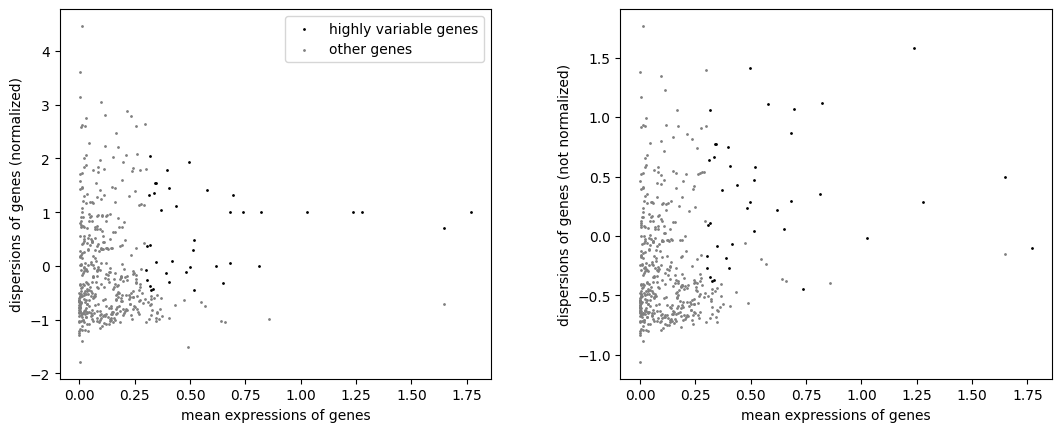

In [57]:
sc.pp.highly_variable_genes(adata, min_mean=0.3, max_mean=7, min_disp=-0.5)
sc.pl.highly_variable_genes(adata)

In [58]:
hv_mask = adata.var['highly_variable'].astype(bool)

hvgs = adata.var_names[hv_mask]

hvgs_list = hvgs.tolist()

n_hvgs = hvgs.size
print(n_hvgs, "highly variable genes")
print(hvgs_list)

40 highly variable genes
['Aif1', 'Axl', 'B2m', 'Bcl2a1b', 'C1qb', 'C1qc', 'Ccl5', 'Ccnd1', 'Cd37', 'Cd79b', 'Col3a1', 'Coro1a', 'Ctsd', 'Ctss', 'Cxcl9', 'Epas1', 'Fn1', 'Ftl1-ps1', 'H2-Ab1', 'Ifitm3', 'Igkc', 'Il18bp', 'Lgals1', 'Lgals3', 'Ly6c2', 'Mertk', 'Mpeg1', 'Ms4a1', 'Naaa', 'Ncoa4', 'Pcbp2', 'Pecam1', 'Ptprc', 'S100a6', 'Sell', 'Serping1', 'Vim', 'Wdfy4', 'Xbp1', 'Zeb2']


computing PCA
    with n_comps=39
    finished (0:00:03)


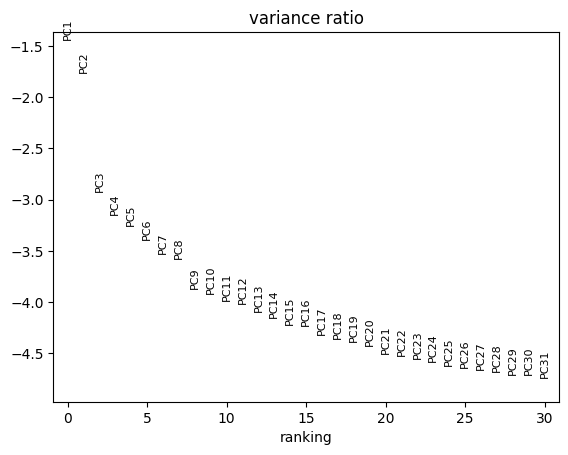

In [59]:
sc.tl.pca(adata, svd_solver='arpack')
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.pca_variance_ratio(adata, log=True)

In [60]:
sc.pp.neighbors(adata, n_neighbors=16, n_pcs=0)

computing neighbors


/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (1:25:49)


In [61]:
if clustering_params['clustering_alg']=='louvain':
    for r in clustering_params['resolutions']:
        sc.tl.louvain(adata,resolution=r,key_added=clustering_params['clustering_alg']+'_'+str(r))

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain_0.2', the cluster labels (adata.obs, categorical) (0:03:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain_0.5', the cluster labels (adata.obs, categorical) (0:02:09)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'louvain_1.1', the cluster labels (adata.obs, categorical) (0:02:21)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 27 clusters and added
    'louvain_1.5', the cluster labels (adata.obs, categorical) (0:01:59)


In [62]:
adata

AnnData object with n_obs × n_vars = 626093 × 480
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'Region_ID', 'Treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'louvain_0.2', 'louvain_0.5', 'louvain_1.1', 'louvain_1.5'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatialdata_attrs', 'log1p', 'hvg', 'pca', 'neighbors', 'louvain_0.2', 'louvain_0.5', 'louvain_1.1', 'louvain_1.5'
    obsm: 's

In [77]:
adata.write_h5ad('adata_JMT_ID8_umap.h5ad')

# SCVI

In [3]:
adata = sc.read_h5ad('adata_JMT_ID8_umap.h5ad')

In [1]:
import sklearn
import scvi
import torch
print("sklearn:", sklearn.__version__)
print("scvi-tools:", scvi.__version__)
print("torch:", torch.__version__)

sklearn: 1.7.1
scvi-tools: 1.3.3
torch: 2.3.1+cu121


In [4]:
import scvi
scvi.model.SCVI.setup_anndata(adata, batch_key='Region_ID')
model = scvi.model.SCVI(adata)
model.train()  
# set max_epochs accordingly
adata.obsm['X_scVI'] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep='X_scVI'); sc.tl.umap(adata)

/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training:   0%|          | 0/13 [00:00<?, ?it/s]

/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_K

In [5]:
adata

AnnData object with n_obs × n_vars = 626093 × 480
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'Region_ID', 'Treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'louvain_0.2', 'louvain_0.5', 'louvain_1.1', 'louvain_1.5', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Region_ID_colors', 'Treatment_colors', 'dendrogram_louvain_0.2', 'dendrogram_louvain_0.5', 'dend

# Compute UMAP and Louvain

In [8]:
if clustering_params['clustering_alg']=='louvain':
    for r in clustering_params['resolutions']:
        sc.tl.louvain(adata,resolution=r,key_added=clustering_params['clustering_alg']+'_'+str(r))

In [45]:
sc.tl.louvain(adata,resolution=2,key_added="louvain_2")

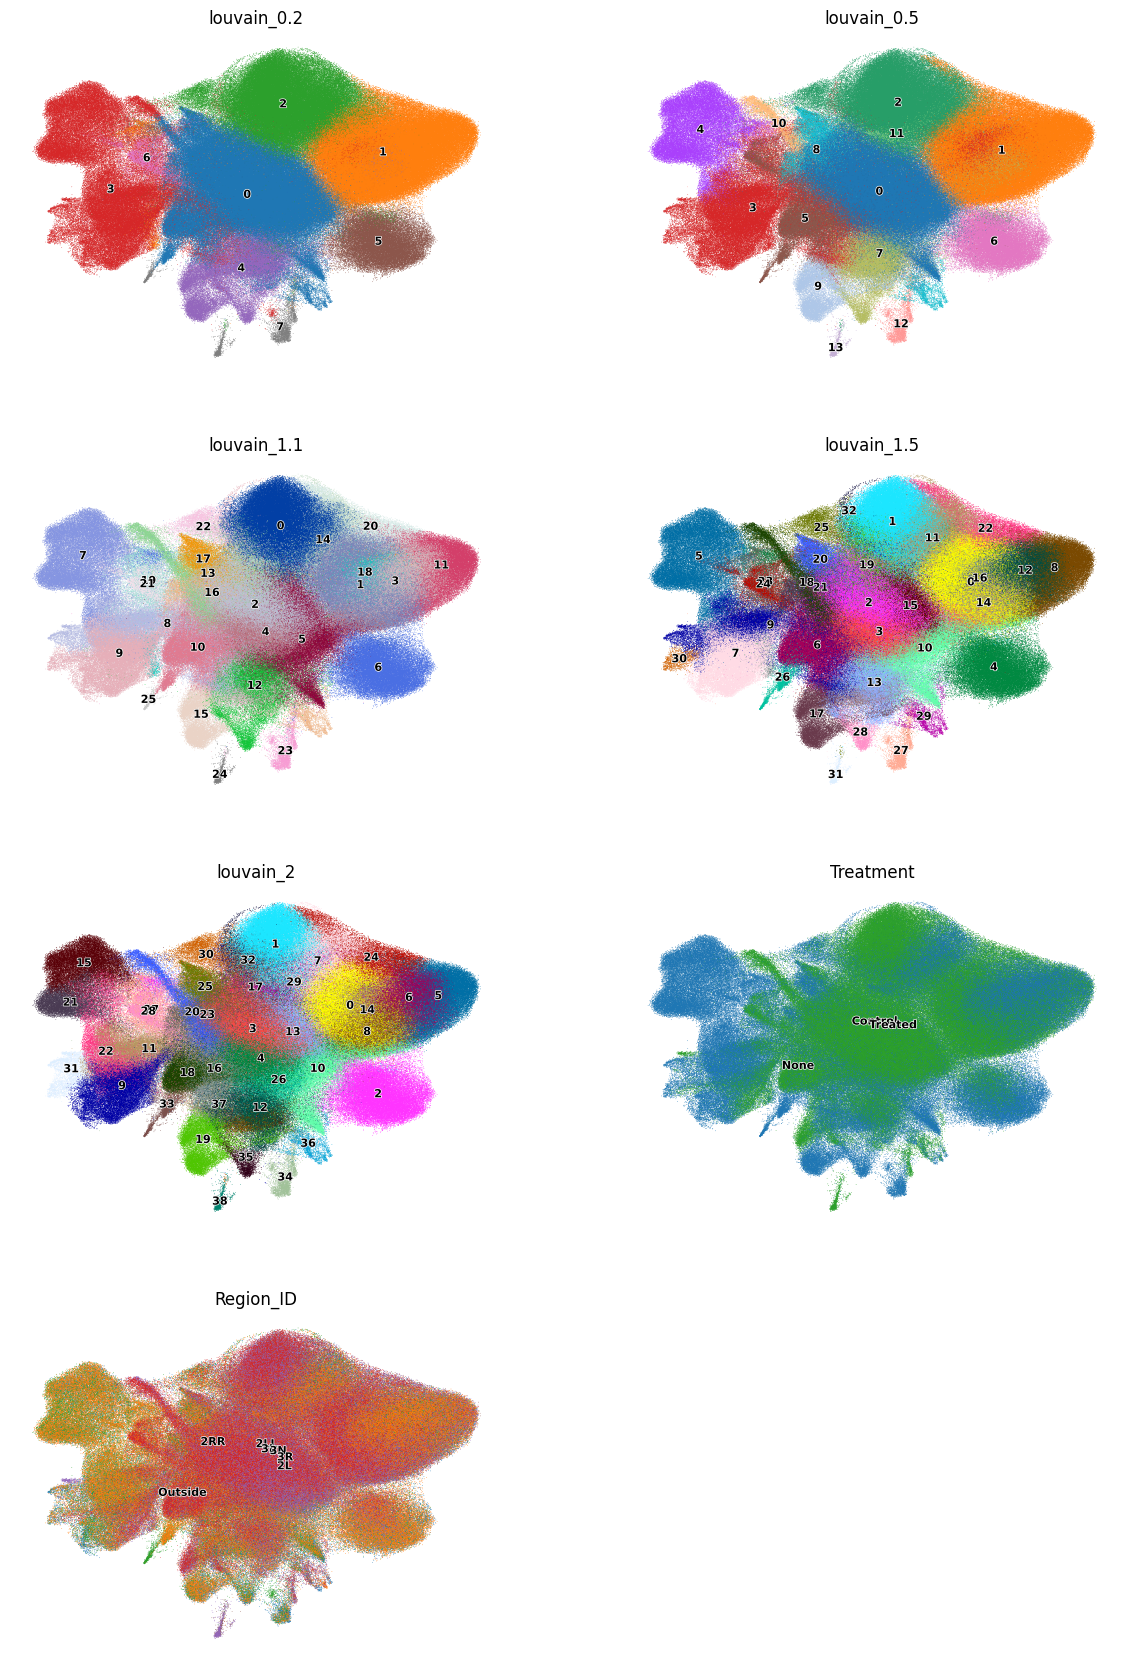

In [47]:
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.umap(adata,color=["louvain_0.2", "louvain_0.5", "louvain_1.1", "louvain_1.5", "louvain_2",
                            "Treatment", "Region_ID"],
               size=1,legend_loc="on data",
               legend_fontsize=8,
               legend_fontoutline=1,ncols=2, 
               show=True,frameon=False)

/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/sc/arion/work/singhb22/test-env/envs/squidpy/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


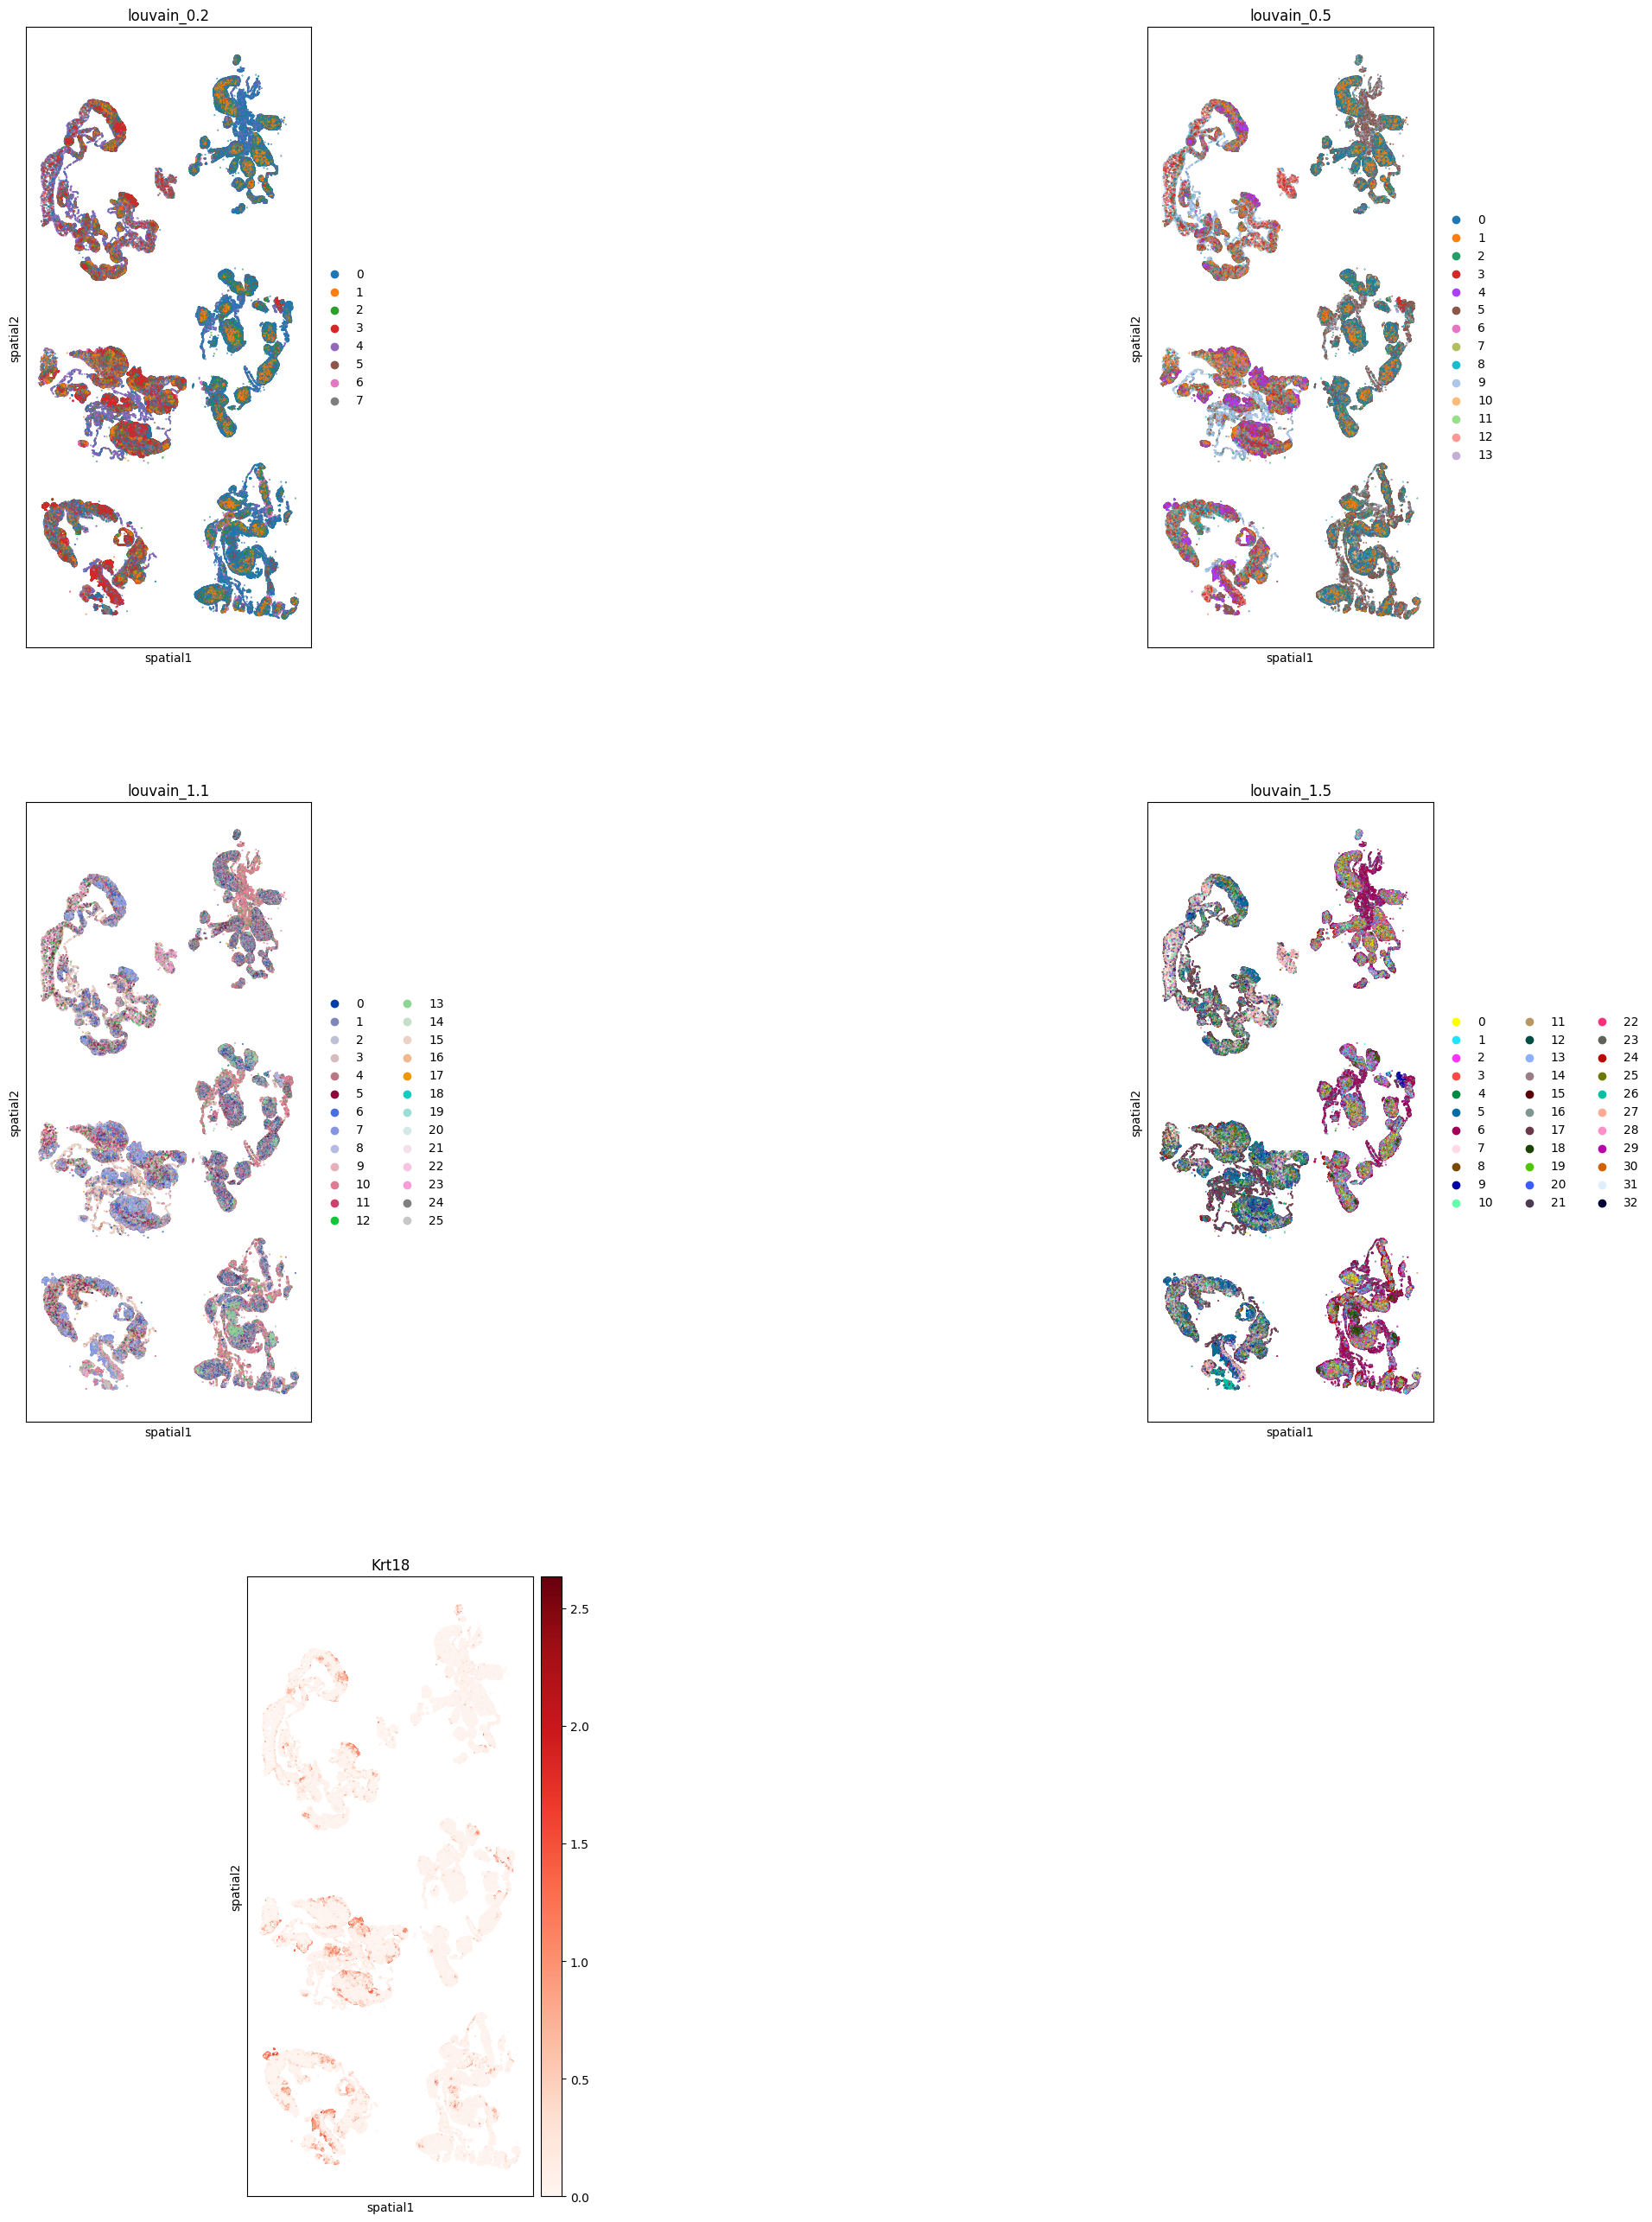

In [14]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=["louvain_0.2", "louvain_0.5", "louvain_1.1", "louvain_1.5", "Krt18"],
    wspace=0.4,frameon=False,
    ncols=2,
    cmap="Reds",
    figsize=(10, 10)
)

In [59]:
adata.write_h5ad('adata_JMT_ID8_umap_batch_corrected.h5ad')

In [78]:
adata.write_h5ad('adata_JMT_ID8_umap.h5ad')